# Parte 2 del concurso de detección de clickbait

In [1]:
%pip install transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Importar bibliotecas

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import Dataset
import csv
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter

## Cargar dataset

In [4]:
df = pd.read_csv('TA1C_dataset_detection_train.csv')

df = df.drop(['Tweet Date', 'Media Name', 'Media Origin'], axis=1)

## Separar dataset

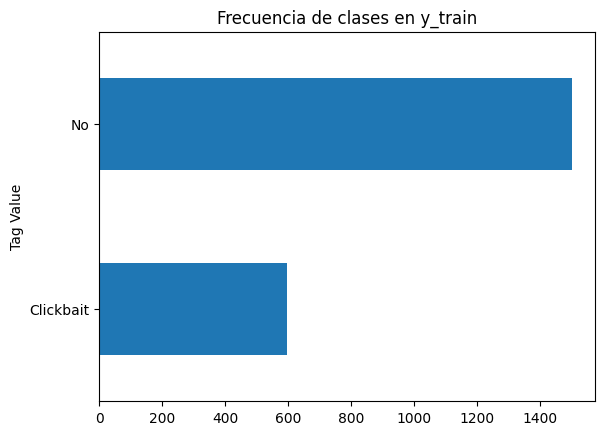

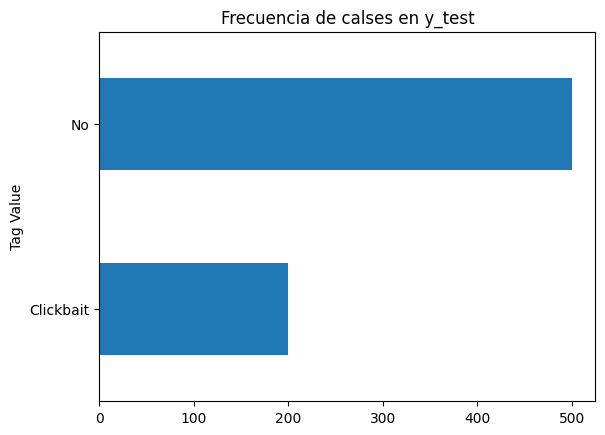

In [5]:
# Separar dataset
X = df['Teaser Text']
y = df['Tag Value']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=0,
    stratify=y)

le = LabelEncoder()
y_train_labels = le.fit_transform(y_train)
y_test_labels = le.transform(y_test)

y_train.value_counts(ascending=True).plot.barh()
plt.title("Frecuencia de clases en y_train")
plt.show()

y_test.value_counts(ascending=True).plot.barh()
plt.title("Frecuencia de calses en y_test")
plt.show()

## Carga del modelo

In [6]:
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)

class CustomDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings=encodings
    self.labels=labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_train_labels)
test_dataset = CustomDataset(test_encodings, y_test_labels)

model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="macro")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [8]:
training_args = TrainingArguments(
    output_dir="output",
    eval_strategy="steps",
    eval_steps=100,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: omarveco (omarveco-instituto-polit-cnico-nacional) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1
100,No log,0.329344,0.878571,0.842499
200,No log,0.429681,0.872857,0.839001
300,No log,0.533562,0.880000,0.844627
400,No log,0.503606,0.891429,0.854683
500,0.282900,0.488247,0.891429,0.861827
600,0.282900,0.542387,0.894286,0.864545
700,0.282900,0.626327,0.878571,0.854443


TrainOutput(global_step=789, training_loss=0.19744619458951576, metrics={'train_runtime': 116.2484, 'train_samples_per_second': 54.194, 'train_steps_per_second': 6.787, 'total_flos': 359362423854000.0, 'train_loss': 0.19744619458951576, 'epoch': 3.0})

## Predicción en el conjunto de prueba

### Cargar dataset de testeo

In [9]:
df_test = pd.read_csv('TA1C_dataset_detection_dev_gold.csv')
df_test = df_test.drop(['Tweet Date', 'Media Name', 'Media Origin'], axis=1)

X_test = df_test['Teaser Text']
y_test = df_test['Tag Value']

test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)
y_test_labels = le.transform(y_test)

test_dataset = CustomDataset(test_encodings, y_test_labels)

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(test_dataset)

predicted_classes = np.argmax(predictions.predictions, axis=1)

report = classification_report(y_test_labels, predicted_classes)

print(report)


              precision    recall  f1-score   support

           0       0.84      0.82      0.83       203
           1       0.93      0.94      0.93       497

    accuracy                           0.90       700
   macro avg       0.88      0.88      0.88       700
weighted avg       0.90      0.90      0.90       700



In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Matriz de confusión normalizada")
  plt.show()

[0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 

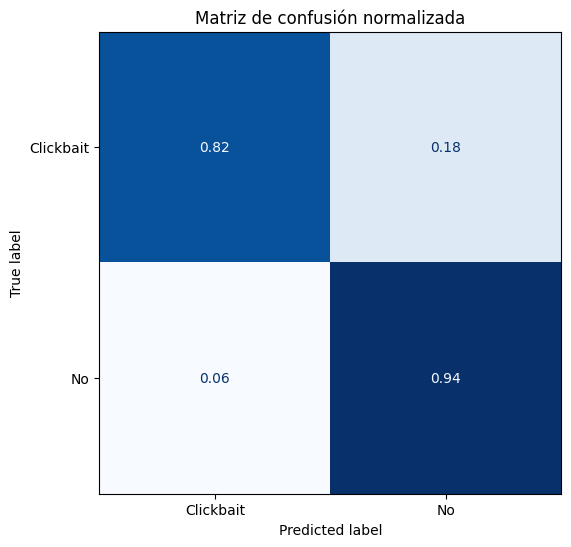

In [12]:
import numpy as np

label_name = np.unique(y)
y_test = y_test_labels.tolist()
print(y_test)
plot_confusion_matrix(predicted_classes, y_test, label_name)